## Imports

In [ ]:
from dataclasses import dataclass, field
import traceback
from typing import List, Dict, Optional, Tuple, Union
import random as rand
import string
import pandas as pd
import csv

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

import json
from dataclasses import asdict

from tqdm import tqdm
import re

## Util Functions

In [ ]:
@dataclass
class Example:
    id: int
    words: List[str]
    labels: List[str]
    pmid: Optional[str] = None
    labelled_tokens: List[Tuple[str, str]] = field(default_factory=list)
    indexed_tokens: List[Tuple[str, int]] = field(default_factory=list)
    label_ids: Optional[List[int]] = None
    has_punctuation_in_entities: bool = False
    has_hyphen_entity: bool = False
    has_consecutive_similar_entities: bool = False
    has_stopword_entity: bool = False
    # NOT INCLUDED IN Example to Df function.
    pooled_entities: Optional[List[Tuple[str, str]]] = field(default_factory=list)
    pooled_entities_w_e_id: Optional[List[Tuple[str, str, str]]] = field(default_factory=list)
    pooled_entity_count: Optional[int] = 0
    pooled_entity_spans: List[Tuple[int, int]] = None
    char_spans: List[Tuple[int, int]] = None
    
    entity_type: Optional[List[str]] = None
    text_w_entity_tags: List[str] = None
    entity_span_w_marker: Optional[List[Tuple[int, int]]] = None
    entity_span_w_tags: Optional[List[Tuple[int, int]]] = None
    text_w_entity_markers: List[str] = None


# Label to ID mapping
Label2Ids = {
    'O': 0,
    'B-DNA': 1,
    'I-DNA': 2,
    'B-RNA': 3,
    'I-RNA': 4,
    'B-cell_line': 5,
    'I-cell_line': 6,
    'B-cell_type': 7,
    'I-cell_type': 8,
    'B-protein': 9,
    'I-protein': 10
    }


label2tag = {
    0: "O",
        1: "@DNA", 2: "@DNA",
        3: "@RNA", 4: "@RNA",
        5: "@CELL_LINE", 6: "@CELL_LINE",
        7: "@CELL_TYPE", 8: "@CELL_TYPE",
        9: "@PROTEIN", 10: "@PROTEIN"
    }


# Example stopwords list
stopwords = {"and", "the", "or", "can", "to"}

In [ ]:
# Function to process the input text and handle all steps
def process_example(file_path: str) -> Dict[int, Example]:
    examples = {}
    sentence_id = 0
    words, labels = [], []

    with open(file_path, 'r') as file:
        for line in tqdm(file, desc="Extracting lines", ncols=80):
            line = line.strip()
            if line:  # If the line is not empty
                word, label = line.split('\t')  # Split on tab space
                words.append(word)
                labels.append(label)
            else:  # End of sentence
                if words and labels:
                    example = Example(id=sentence_id, words=words, labels=labels)
                    example.labelled_tokens = list(zip(words, labels))
                    example.label_ids = [Label2Ids[label] for label in labels]
                    punctuation = set(string.punctuation) - {'-'}
                    for word, label_id in zip(words, example.label_ids):
                        if label_id != 0 and any(char in punctuation for char in word):
                            example.has_punctuation_in_entities = True
                    for word, label_id in zip(words, example.label_ids):
                        if label_id != 0 and '-' in word:
                            example.has_hyphen_entity = True
                    for i in range(1, len(example.label_ids)):
                        if example.label_ids[i] == example.label_ids[i - 1] and example.label_ids[i] != 0:
                            example.has_consecutive_similar_entities = True
                            break
                    for word, label_id in zip(words, example.label_ids):
                        if label_id != 0 and word.lower() in stopwords:
                            example.has_stopword_entity = True
                    examples[sentence_id] = example
                    sentence_id += 1
                    words, labels = [], []  # Reset for the next sentence

        # Add the last sentence if the file doesn't end with a blank line
        if words and labels:
            example = Example(id=sentence_id, words=words, labels=labels)
            example.labelled_tokens = list(zip(words, labels))
            example.label_ids = [Label2Ids[label] for label in labels]
            
            punctuation = set(string.punctuation) - {'-'}
            for word, label_id in zip(words, example.label_ids):
                if label_id != 0 and any(char in punctuation for char in word):
                    example.has_punctuation_in_entities = True

            for word, label_id in zip(words, example.label_ids):
                if label_id != 0 and '-' in word:
                    example.has_hyphen_entity = True

            for i in range(1, len(example.label_ids)):
                if example.label_ids[i] == example.label_ids[i - 1] and example.label_ids[i] != 0:
                    example.has_consecutive_similar_entities = True
                    break

            for word, label_id in zip(words, example.label_ids):
                if label_id != 0 and word.lower() in stopwords:
                    example.has_stopword_entity = True

            examples[sentence_id] = example

    return examples


def view_example(data: Dict[int, Example], random=True,ID=None, sorted: bool = False):
    
    """ Function to view an instance of the dataclass Example
    Argument(s): Example (dataclass), random (boolean) [Def: True], ID (int) [Def: None] 
    Return(s): None
    """

    if random:
        id = rand.choice(list(data.keys()))
    elif random==False and sorted == True:
        pass
    else:
        id = ID
    example = data[id]
    print("ID:", id)
    print("PMID: ", example.pmid)
    print("Words:", example.words)
    print("Labels:", example.labels)
    print("Labelled Tokens:", example.labelled_tokens)
    print("Indexed Tokens: ", example.indexed_tokens)
    print("Label IDs:", example.label_ids)
    print("Has punctuation in entities:", example.has_punctuation_in_entities)
    print("Has hyphen entity:", example.has_hyphen_entity)
    print("Has consecutive similar entities:", example.has_consecutive_similar_entities)
    print("Has stopword entity:", example.has_stopword_entity)
    print("Pooled Entities:", example.pooled_entities)
    print("Pooled Entities with Entity Ids:", example.pooled_entities_w_e_id)
    print("Pooled Entity Count: ", example.pooled_entity_count)
    print("Pooled Entities Span:", example.pooled_entity_spans)
    print("Char Spans:", example.char_spans)
    print("Entity Types:", example.entity_type)
    print("Text: ", " ".join(example.words))
    print("Text (with entity markers):", example.text_w_entity_markers)
    print("Entity Span (with marker):", example.entity_span_w_marker)
    print("Text (with entity tags)", example.text_w_entity_tags)
    print("Entity Span (with tags):", example.entity_span_w_tags)
    print("\n")


def view_examples(data: Dict[int, Example],num_examples:int=5):
    
    """ Function to view multiple instances of the dataclass Example at a time.
    Argument(s): Example (dataclass), num_examples (int) [Def: 5]
    Return(s): None
    """

    if num_examples == None:
        view_example(data)
    else:
        for i in range(num_examples):
            view_example(data) 


def examples_to_dataframe(examples: Dict[int, Example]) -> pd.DataFrame:
    # Create a list of dictionaries where each dictionary is a row in the DataFrame
    data = []
    
    for example in examples.values():
        data.append({
            'id': example.id,
            'words': " ".join(example.words),  # Join the words into a single string
            'labels': " ".join(example.labels),  # Join the labels into a single string
            'labelled_tokens': example.labelled_tokens,  # List of (word, label) tuples
            'label_ids': example.label_ids,  # List of label IDs
            'has_punctuation_in_entities': example.has_punctuation_in_entities,
            'has_hyphen_entity': example.has_hyphen_entity,
            'has_consecutive_similar_entities': example.has_consecutive_similar_entities,
            'has_stopword_entity': example.has_stopword_entity
        })

    df = pd.DataFrame(data)
    
    return df

# Function to check if a word is punctuation or a stopword
def is_punctuation_or_stopword(word: str) -> bool:
    punctuation = {',', '.'}
    return word.lower() in stopwords or any(char in punctuation for char in word)


# Function to perform entity mention pooling
def entity_mention_pooling(example: Example) -> Example:
    # List to store pooled entities and spans
    pooled_entities = []
    entity_spans = []

    i = 0
    while i < len(example.words):
        label = example.labels[i]
        label_id = example.label_ids[i]
        if label.startswith('B-') or (label.startswith('I-') and (i == 0 or not example.labels[i-1].startswith('B-'))):
            start = i
            entity_tokens = [example.words[i]]  # Collect the entity tokens
            entity_label = label  # Get the entity label type
            entity_tag = label2tag[label_id]  # Map label_id to entity tag

            while i + 1 < len(example.words):
                next_label = example.labels[i + 1]
                next_label_id = example.label_ids[i + 1]
                next_word = example.words[i + 1]

                if next_label.startswith('I-') and next_label[2:] == entity_label[2:]:
                    i += 1
                    entity_tokens.append(next_word)
                # Stop if punctuation (except hyphen) is encountered
                elif is_punctuation_or_stopword(next_word) and next_word != '-':
                    break
                # Stop if a new B- entity or non-matching I- label is encountered
                elif next_label.startswith('B-') or not next_label.startswith('I-'):
                    break
                else:
                    i += 1
                    entity_tokens.append(next_word)
            concatenated_tokens = " ".join(entity_tokens)
            pooled_entities.append((concatenated_tokens, entity_tag))
            entity_spans.append((start, i))

        i += 1

    
    example.pooled_entities = pooled_entities
    example.pooled_entity_spans = entity_spans
    example.pooled_entity_count = len(pooled_entities)

    entity_with_ids = []
    for i in range(len(pooled_entities)):
        entity_id = f"E_{i+1}"
        entity, entity_tag = pooled_entities[i]
        entity_with_ids.append((entity,entity_tag,entity_id))
    
    example.pooled_entities_w_e_id = entity_with_ids

    return example


def find_entities(label_ids: List[int]) -> List[Tuple[int, int]]:
    """
    Function to find and return the start and end indices of entities in a sequence of label IDs.

    Argument(s): 
        label_ids (List[int]): A list of label IDs where non-zero values represent parts of entities.

    Return(s):
        List[Tuple[int, int]]: A list of tuples, where each tuple contains the start and end indices 
                               of an entity in the label sequence.
    """
    entities = []
    i = 0
    while i < len(label_ids):
        if label_ids[i] != 0:
            start = i
            while i + 1 < len(label_ids) and label_ids[i + 1] == label_ids[i] + 1:
                i += 1
            end = i
            entities.append((start, end))
        i += 1
    return entities


def calculate_entity_spans(example: Example) -> List[Tuple[int, int]]:
    """
    Calculate token-wise spans of each entity in the pooled_entities based on the label_ids.

    Argument(s):
        example (Example): The Example dataclass instance that contains words, labels, pooled entities, etc.

    Return(s):
        List[Tuple[int, int]]: A list of tuples where each tuple contains the start and end token indices
                                corresponding to the entities in pooled_entities.
    """

    pooled_entity_spans = []
    entity_idx = 0

    for entity, _ in example.pooled_entities:
        # Split the entity into tokens and store the length for efficiency
        entity_tokens = entity.split()
        num_entity_tokens = len(entity_tokens)

        first_token_idx = None
        last_token_idx = None
        for i, word in enumerate(example.words):
            if word == entity_tokens[0]:
                first_token_idx = i
                break
            elif word == entity_tokens[num_entity_tokens-1]:
                last_token_idx = i
                break
        
        pooled_entity_spans.append((first_token_idx,last_token_idx))

    return pooled_entity_spans


def set_indexed_tokens(data: Example):
    i = 0
    for i in tqdm(range(len(data)), desc="Setting indexed tokens", ncols=80):
        example = data[i]
        words = example.words
        example.indexed_tokens = list(enumerate(words))


def calculate_char_span(words: List[str], entity_span: Tuple[int, int]) -> Tuple[int, int]:
    char_span = (0, 0)
    char_counter = 0
    start_idx, end_idx = entity_span

    for i, word in enumerate(words):
        if i == start_idx:
            start_char_idx = char_counter
        char_counter += len(word)
        if i < len(words) - 1:
            char_counter += 1  # Add one for the space after the word
        try:
            if i == end_idx:
                end_char_idx = char_counter  # Set the end index
                if word[-1] in string.punctuation:
                    end_char_idx -= 1  # Reduce by 1 to exclude punctuation
                char_span = (start_char_idx, end_char_idx)
                break
        except Exception as e:
            f"{e} discovered in example {i}" 
    
    return char_span


def label_count(data: Dict[int, Example]) -> List[int]:
    """ Function to count the number of entities identified in each sentence. This function is primarily used to count and identify the sentences/-
    sequences without any predicted entities.
    Argument(s): Example (dataclass)
    Return(s): List of int
    """
    label_counts = []
    for i in range(len(data)):
        count = sum(1 for label in data[i].label_ids if label != 0)
        label_counts.append(count)
    return label_counts


def drop_null_sentences(data: Dict[int, Example], label_count: List[int], condition: int=0, return_discarded_indexes: bool=False):
    
    """ Function to drop sentences/sequences without any predicted entities. Uses the entity_count list to expedite the process.
    Argument(s): data (dataclass Example), label_count (List of int), condition (int) [def=0], return_discarded_indexes (bool) [def=False]
    Return(s): None
    """

    discarded_entries = []
    # Typical reverse loop iteration.
    for i in range(len(label_count)-1, -1, -1): # The second argument refers to the stopping of loop, that is on "index 0". The third arg refers to the step decreasing by 1 at every other step.
        if label_count[i]<=condition:
            discarded_entries.append(i)
            del data[i]
    
    if return_discarded_indexes:
        return discarded_entries
    else:
        return None


def sort_Examples(data: Dict[int, Example]) -> Dict[int, Example]:
    
    """ Function to sort the instances within the dataclass Example. This function is primarily implemented after the function-
    `drop_null_sentences()` have been implemented. For example:
    In the following scenario, amongst the ordered [5,6,7,8,9], the sequences [5,8] were dropped. This causes the instances to become unordered-
    where the sequence is arranged as such [6,7,9]. In these instances, for loops can be a bit complex. Hence the following function helps reorder-
    the unordered list.  
    Argument(s): data (dataclass Example)
    Return(s): dict (dataclass Example)
    """

    new_data = {}
    for new_index, key in tqdm(enumerate(sorted(data.keys())), total=len(data), desc="Sorting Examples", ncols=80):
        new_data[new_index] = data[key]
    return new_data


def set_pmid(csv_file_path: str, examples: Dict[int,Example]) -> None:
    """ Loads the csv file comprising of all the segmented sentences, uses the indexed rows from the csv file to set a comprehensive pmid id to each
    example. Since each row indicates a sentence, therefore the pmid should be formatted as: {pmid}_{sent_no}. Must be implemented before splitting
    entities into groups of two.
    """
    df = pd.read_csv(csv_file_path)
    df["formatted_pmid"] = df.apply(lambda row: f"{int(row['pmid'])}_{int(row['sent_no'])}", axis=1)
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Setting PMID", ncols=80):
        if idx in examples:
            examples[idx].pmid = str(row['formatted_pmid'])



def split_entity_into_groups(examples: Dict[int, Example]) -> Dict[str, Union[Example, Dict[str, Example]]]: 
  """
  Leverages the number of entities in each example to divide them into groups of two.
  The function also utilizes pmid to keep track of its division.

  :param examples: Dictionary of Example objects indexed by integers.
  :param pairs: List of tuples representing integer pairs for grouping entities.
  :return: A list of examples split into groups, a list of single-entity examples.
  """

  relation_examples = {}  # Examples with more than 1 entity, divided into groups of two
  single_examples = {}  # Examples with exactly 1 entity
  c = 0
  k = 0
  for i in tqdm(range(len(examples)), desc="Splitting Entities into pairs", ncols=80):
    example = examples[i]

    if example.pooled_entity_count > 1:
      pmid_base = example.pmid  # Save original pmid for modification
      entity_pairs = generate_pairs(n=example.pooled_entity_count)
      
      pooled_entities = example.pooled_entities
      pooled_entity_spans = example.pooled_entity_spans
      char_spans = example.char_spans
      
      for j in range(len(entity_pairs)):
        entity_pair = entity_pairs[j]
        entity1_idx, entity2_idx = entity_pair

        entity1_idx -= 1
        entity2_idx -= 1

        entity_1 = pooled_entities[entity1_idx]
        entity_1_span = pooled_entity_spans[entity1_idx]
        entity_1_char_span = char_spans[entity1_idx]
        
        entity_2 = pooled_entities[entity2_idx]
        entity_2_span = pooled_entity_spans[entity2_idx]
        entity_2_char_span = char_spans[entity2_idx]

        sub_example = Example(
              id=example.id,
              words=example.words,
              labels=example.labels,
              labelled_tokens=example.labelled_tokens,
              indexed_tokens=example.indexed_tokens,
              label_ids=example.label_ids,
              pmid=f"{pmid_base}_{example.pooled_entity_count}_{j}",
              pooled_entities=[entity_1,entity_2],
              pooled_entity_spans=[entity_1_span,entity_2_span],
              has_punctuation_in_entities=example.has_punctuation_in_entities,
              has_hyphen_entity=example.has_hyphen_entity,
              has_consecutive_similar_entities=example.has_consecutive_similar_entities,
              has_stopword_entity=example.has_stopword_entity,
              pooled_entity_count= 2,
              char_spans=[entity_1_char_span,entity_2_char_span],
          )
        relation_examples[k] = sub_example 
        k += 1

    else:
      # For examples with a single entity, no need to split
      pmid = example.pmid
      example.pmid = f"{pmid}_single"
      single_examples[c] = example
      c += 1

  return {'relation_examples': relation_examples, 'single_examples': single_examples}


def generate_pairs(n):
  """Generates a list of integer pairs from 1 to n.

  Args:
    n: The maximum integer in the pairs.

  Returns:
    A list of tuples, where each tuple represents a pair of integers.
  """

  pairs = []
  for i in range(1, n):
    for j in range(i + 1, n + 1):
      pairs.append((i, j))
  return pairs


def set_entity_tags_and_markers(examples: Dict[int, Example]):
    """ Adds entity markers and tags to the text of each example. """
    
    for i in tqdm(range(len(examples)), desc="Setting entity tags and markers", ncols=80):
        example = examples[i]
        entity_pairs = example.pooled_entities
        text = " ".join(example.words)
        
        marker_modified_text = text
        tag_modified_text = text
        char_span_w_markers_pool = []
        char_span_w_tags_pool = []
        entity_type_pool = []
        
        offset_marker = 0  # Track changes to the text length due to marker insertion
        offset_tag = 0     # Track changes to the text length due to tag insertion
        
        for idx, ((entity, entity_type), char_span) in enumerate(zip(entity_pairs, example.char_spans)):
            start, end = char_span
            
            # Creating markers and tags for the current entity
            marker_prefix = f"[E{idx+1}]"
            marker_suffix = f"[/E{idx+1}]"
            tag_prefix = f"[{entity_type}]"
            tag_suffix = f"[/{entity_type}]"
            
            # Adjusting the start and end positions for markers
            marker_start = start + offset_marker
            marker_end = end + offset_marker
            entity_text = text[start:end]
            marker_entity = f"{marker_prefix}{entity_text}{marker_suffix}"
            
            # Modifying the marker text using slicing
            marker_modified_text = (
                marker_modified_text[:marker_start] +
                marker_entity +
                marker_modified_text[marker_end:]
            )

            offset_marker += len(marker_prefix) + len(marker_suffix)
            
            # Adjust start and end positions for tags
            tag_start = start + offset_tag
            tag_end = end + offset_tag
            tagged_entity = f"{tag_prefix}{entity_text}{tag_suffix}"
            
            tag_modified_text = (
                tag_modified_text[:tag_start] +
                tagged_entity +
                tag_modified_text[tag_end:]
            )
            # Update offset due to tag insertion
            offset_tag += len(tag_prefix) + len(tag_suffix)
            
            char_span_w_markers_pool.append((marker_start, marker_start + len(marker_entity)))
            char_span_w_tags_pool.append((tag_start, tag_start + len(tagged_entity)))
            entity_type_pool.append(entity_type)
        
        example.text_w_entity_markers = marker_modified_text
        example.text_w_entity_tags = tag_modified_text
        example.entity_span_w_marker = char_span_w_markers_pool
        example.entity_span_w_tags = char_span_w_tags_pool
        example.entity_type = entity_type_pool

def save_examples_to_jsonl(examples: Dict[int, Example], output_file: str) -> None:
    """
    Function to save all the Example dataclass instances to a JSONL file.
    
    Args:
    examples (Dict[int, Example]): A dictionary of Example dataclass instances.
    output_file (str): The path where the JSONL file will be saved.
    
    Returns:
    None
    """
    with open(output_file, 'w') as f:
        for example_id, example in examples.items():

            # Assign values to new dict
            pooled_entities = example.pooled_entities
            entity_tuple_1 = pooled_entities[0]
            entity_tuple_2 = pooled_entities[1]
            entity_1,entity_1_type = entity_tuple_1
            entity_2,entity_2_type = entity_tuple_2

            pooled_entity_spans = example.char_spans
            entity_span_tuple_1 = pooled_entity_spans[0]
            entity_span_tuple_2 = pooled_entity_spans[1]
            start_idx_1,end_idx_1 = entity_span_tuple_1
            start_idx_2,end_idx_2 = entity_span_tuple_2

            pooled_entity_spans_w_markers = example.entity_span_w_marker
            entity_span_w_marker_tuple_1 = pooled_entity_spans_w_markers[0]
            entity_span_w_marker_tuple_2 = pooled_entity_spans_w_markers[1]
            startm_idx_1,endm_idx_1 = entity_span_w_marker_tuple_1
            startm_idx_2,endm_idx_2 = entity_span_w_marker_tuple_2

            new_dict = {
                "id":example.pmid,
                "text": " ".join(example.words),
                "text_with_entity_marker":example.text_w_entity_markers,
                "relation":[
                    {
                        "relation_type": "Negative", 
                        "relation_id": 2, 
                        "entity_1": entity_1, 
                        "entity_1_idx": [start_idx_1,end_idx_1], 
                        "entity_1_idx_in_text_with_entity_marker": [startm_idx_1,endm_idx_1], 
                        "entity_1_type": entity_1_type, 
                        "entity_1_type_id": 0, 
                        "entity_2": entity_2, 
                        "entity_2_idx": [start_idx_2,end_idx_2], 
                        "entity_2_idx_in_text_with_entity_marker": [startm_idx_2,endm_idx_2], 
                        "entity_2_type": entity_2_type, 
                        "entity_2_type_id": 0,
                    }
                ],
                "directed": False, 
                "reverse": False
            }
            
            # Write the dictionary to a new line in the JSONL file
            f.write(json.dumps(new_dict) + '\n')
            

    print(f"Data saved to {output_file}")


def extract_entities(example: Example) -> pd.DataFrame:
    # Helper function to split pmid and sentence_no
    def split_pmid_and_sentence_no(pmid_str: str):
        
        # Split the string by underscores
        parts = pmid_str.split('_')
        
        # Convert parts to integers where possible
        try:
            # Extract `pmid` and `sentence_no` from parts, handling varying lengths
            pmid = parts[0] if len(parts) > 0 and parts[0].isdigit() else None
            sentence_no = parts[1] if len(parts) > 1 and parts[1].isdigit() else None
            
            # Optional: handle a third component if needed
            third_component = parts[2] if len(parts) > 2 and parts[2].isdigit() else None
            
            
            return pmid, sentence_no
        
        except Exception as e:
            print(f"PMID Before: {pmid_str}")
            print(f"PMID after: {pmid}, sentence_no: {sentence_no}, third_component: {third_component}")
            traceback.print_exc()

    pmid, sentence_no = split_pmid_and_sentence_no(example.pmid)
    text = " ".join(example.words)
    total_entity_no = len(example.pooled_entities_w_e_id)

    data = []
    for i, (entity_name, entity_type, entity_id) in enumerate(example.pooled_entities_w_e_id):
        entity_data = {
            "pmid": int(pmid),
            "sentence_no": int(sentence_no),
            "total_entity_no": total_entity_no,
            "entity_name": entity_name,
            "entity_type": entity_type,
            "entity_id": entity_id,
            "text": text
        }
        
        data.append(entity_data)

    return data

def create_entity_dataframe(examples: Dict[int, Example]) -> pd.DataFrame:
    # List to hold dictionaries for each entity from all examples
    all_data = []
    i = 0
    # Loop through examples with tqdm for progress tracking
    print(f"Length of examples: {len(examples)}")
    for i in tqdm(range(len(examples)), desc="Processing Examples"):
        example = examples[i]
        # Extract data for each example and extend `all_data` list
        example_data = extract_entities(example)
        all_data.extend(example_data)
    
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(all_data)
    
    return df

    

## Merging Inference Predictions to Dengue PubMed Abstract dataset (`segmented_unfiltered.csv`).

In [ ]:
# Inputs
file_path = "D:/CSE498R_Resources/D3N/Dengue-Drug-Discovery-Network-D3N/Data/d3n_JNLPBA/output/NER/jnlpba/inference_predictions.txt"
csv_file_path = "D:/CSE498R_Resources/D3N/Dengue-Drug-Discovery-Network-D3N/Data/output/unfiltered/segmented_unfiltered.csv"

# Data Pre-processing Pipeline
examples = process_example(file_path=file_path)
print(len(examples))
set_pmid(csv_file_path=csv_file_path,examples=examples)
set_indexed_tokens(examples)
# view_examples(examples)

for i in tqdm(range(len(examples)), desc="Performing Entity Mention Pooling", ncols=80):
    example = examples[i]
    example = entity_mention_pooling(example)

print(len(examples))
# Specific test:
print("\n\n")
label_counts = label_count(examples)
drop_null_sentences(examples,label_counts)
examples = sort_Examples(examples)
print("\n\n Sorted Examples")
view_examples(examples)
print(f"Length of Total Examples: {len(examples)}\n")
for i in tqdm(range(len(examples)), desc="Calculating Char Span", ncols=80):
    example = examples[i]
    char_spans = []
    for entity_span in example.pooled_entity_spans:
        span = calculate_char_span(words=example.words,entity_span=entity_span)
        char_spans.append(span)
    
    example.char_spans = char_spans
print("\n\nSorted Examples after adding char spans")
view_examples(examples)
print("\n\nCreating separate entity dataframe")
entity_df = create_entity_dataframe(examples)
splitted_examples = split_entity_into_groups(examples)
relation_examples = splitted_examples["relation_examples"]
single_examples = splitted_examples["single_examples"]
print("\n\nSorted Relation Examples after splitting")
view_example(relation_examples)
set_entity_tags_and_markers(relation_examples)
print("\n\nSorted Relation Examples after setting entity tags and markers")
view_examples(relation_examples)

Extracting lines: 2503998it [00:06, 364555.30it/s]


131337


Setting indexed tokens: 100%|███████| 131337/131337 [00:00<00:00, 278411.40it/s]
Performing Entity Mention Pooling: 100%|█| 131337/131337 [00:02<00:00, 61278.89i


131337





Sorting Examples: 100%|██████████████| 30262/30262 [00:00<00:00, 2328826.44it/s]




 Sorted Examples
ID: 30094
PMID:  26174727_2
Words: ['He', 'was', 'positive', 'for', 'NS1', '(non-structural', 'protein-1)', 'antigen', 'and', 'IgM', 'antibody', 'for', 'dengue.']
Labels: ['O', 'O', 'O', 'O', 'B-protein', 'I-protein', 'I-protein', 'I-protein', 'O', 'B-protein', 'I-protein', 'O', 'O']
Labelled Tokens: [('He', 'O'), ('was', 'O'), ('positive', 'O'), ('for', 'O'), ('NS1', 'B-protein'), ('(non-structural', 'I-protein'), ('protein-1)', 'I-protein'), ('antigen', 'I-protein'), ('and', 'O'), ('IgM', 'B-protein'), ('antibody', 'I-protein'), ('for', 'O'), ('dengue.', 'O')]
Indexed Tokens:  [(0, 'He'), (1, 'was'), (2, 'positive'), (3, 'for'), (4, 'NS1'), (5, '(non-structural'), (6, 'protein-1)'), (7, 'antigen'), (8, 'and'), (9, 'IgM'), (10, 'antibody'), (11, 'for'), (12, 'dengue.')]
Label IDs: [0, 0, 0, 0, 9, 10, 10, 10, 0, 9, 10, 0, 0]
Has punctuation in entities: True
Has hyphen entity: True
Has consecutive similar entities: True
Has stopword entity: False
Pooled Entities: [('

Calculating Char Span: 100%|██████████| 30262/30262 [00:00<00:00, 140477.35it/s]




Sorted Examples after adding char spans
ID: 17658
PMID:  32038660_6
Words: ['Our', 'data', 'indicate', 'that', 'these', 'immunodominant', 'epitopes', 'are', 'recognized', 'in', 'the', 'context', 'of', 'multiple', 'different', 'HLA', 'molecules.']
Labels: ['O', 'O', 'O', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'I-protein']
Labelled Tokens: [('Our', 'O'), ('data', 'O'), ('indicate', 'O'), ('that', 'O'), ('these', 'O'), ('immunodominant', 'B-protein'), ('epitopes', 'I-protein'), ('are', 'O'), ('recognized', 'O'), ('in', 'O'), ('the', 'O'), ('context', 'O'), ('of', 'O'), ('multiple', 'O'), ('different', 'O'), ('HLA', 'B-protein'), ('molecules.', 'I-protein')]
Indexed Tokens:  [(0, 'Our'), (1, 'data'), (2, 'indicate'), (3, 'that'), (4, 'these'), (5, 'immunodominant'), (6, 'epitopes'), (7, 'are'), (8, 'recognized'), (9, 'in'), (10, 'the'), (11, 'context'), (12, 'of'), (13, 'multiple'), (14, 'different'), (15, 'HLA'), (16, 'molecules.')]
Labe

Splitting Entities into pairs: 100%|██| 30262/30262 [00:00<00:00, 133670.22it/s]




Sorted Relation Examples after splitting
ID: 41075
PMID:  27546535_3_3_1
Words: ['The', 'activation', 'of', 'interferon', 'pathways', 'by', 'DENV', 'protected', 'bystander', 'cells', 'from', 'infection', 'and', 'protected', 'the', 'infected', 'cells', 'from', 'massive', 'apoptosis.']
Labels: ['O', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'B-cell_type', 'I-cell_type', 'O', 'O', 'O', 'O', 'O', 'B-cell_type', 'I-cell_type', 'O', 'O', 'O']
Labelled Tokens: [('The', 'O'), ('activation', 'O'), ('of', 'O'), ('interferon', 'B-protein'), ('pathways', 'O'), ('by', 'O'), ('DENV', 'O'), ('protected', 'O'), ('bystander', 'B-cell_type'), ('cells', 'I-cell_type'), ('from', 'O'), ('infection', 'O'), ('and', 'O'), ('protected', 'O'), ('the', 'O'), ('infected', 'B-cell_type'), ('cells', 'I-cell_type'), ('from', 'O'), ('massive', 'O'), ('apoptosis.', 'O')]
Indexed Tokens:  [(0, 'The'), (1, 'activation'), (2, 'of'), (3, 'interferon'), (4, 'pathways'), (5, 'by'), (6, 'DENV'), (7, 'protected'), (8, 'bys

Setting entity tags and markers: 100%|█| 66490/66490 [00:01<00:00, 58123.69it/s]



Sorted Relation Examples after setting entity tags and markers
ID: 46991
PMID:  15498040_4_3_2
Words: ['An', 'inverse', 'correlation', 'between', 'platelet', 'count', 'and', 'PAIgG', 'or', 'PAIgM', 'levels', 'was', 'found', 'in', 'these', 'patients.']
Labels: ['O', 'O', 'O', 'O', 'B-cell_type', 'O', 'O', 'B-protein', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'O']
Labelled Tokens: [('An', 'O'), ('inverse', 'O'), ('correlation', 'O'), ('between', 'O'), ('platelet', 'B-cell_type'), ('count', 'O'), ('and', 'O'), ('PAIgG', 'B-protein'), ('or', 'O'), ('PAIgM', 'B-protein'), ('levels', 'O'), ('was', 'O'), ('found', 'O'), ('in', 'O'), ('these', 'O'), ('patients.', 'O')]
Indexed Tokens:  [(0, 'An'), (1, 'inverse'), (2, 'correlation'), (3, 'between'), (4, 'platelet'), (5, 'count'), (6, 'and'), (7, 'PAIgG'), (8, 'or'), (9, 'PAIgM'), (10, 'levels'), (11, 'was'), (12, 'found'), (13, 'in'), (14, 'these'), (15, 'patients.')]
Label IDs: [0, 0, 0, 0, 7, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0]
Has punctuati

In [ ]:
# For RE Inference
output_file = 'D:/CSE498R_Resources/D3N/Dengue-Drug-Discovery-Network-D3N/Data/output/processed/d3n.json'
save_examples_to_jsonl(relation_examples, output_file)

Data saved to D:/CSE498R_Resources/D3N/Dengue-Drug-Discovery-Network-D3N/Data/d3n_filtered/d3n_2.json


In [ ]:
# For Entity Dataframe
output_file = 'D:/CSE498R_Resources/D3N/Dengue-Drug-Discovery-Network-D3N/Data/output/processed/entities.csv'
entity_df.to_csv(output_file, index = False)

In [71]:
entity_df.head(20)

,pmid,sentence_no,total_entity_no,entity_name,entity_type,entity_id,text
0,19822889,3,1,viral virulence factors,@PROTEIN,E_1,More than 50 years of research on dengue has r...
1,30301880,3,1,heterologous antibodies.,@PROTEIN,E_1,"Each serotype is antigenically different, mean..."
2,30301880,4,1,neutralizing antibodies,@PROTEIN,E_1,Infection with one serotype will create neutra...
3,30301880,7,1,"type I interferon,",@PROTEIN,E_1,Activated innate immune pathways includes type...
4,34696397,3,1,positive-sense single-stranded RNA,@RNA,E_1,The Dengue virus belongs to the Flaviviridae f...
5,34696397,5,2,mammalian host cells,@CELL_TYPE,E_1,"Here in this review article, we will be discus..."
6,34696397,5,2,host proteins,@PROTEIN,E_2,"Here in this review article, we will be discus..."
7,38649998,8,4,"host genome,",@DNA,E_1,This review aims to summarize the complex inte...
8,38649998,8,4,"host genes,",@DNA,E_2,This review aims to summarize the complex inte...
9,38649998,8,4,"viral and host mRNAs,",@RNA,E_3,This review aims to summarize the complex inte...


## Visualizing the entity dist

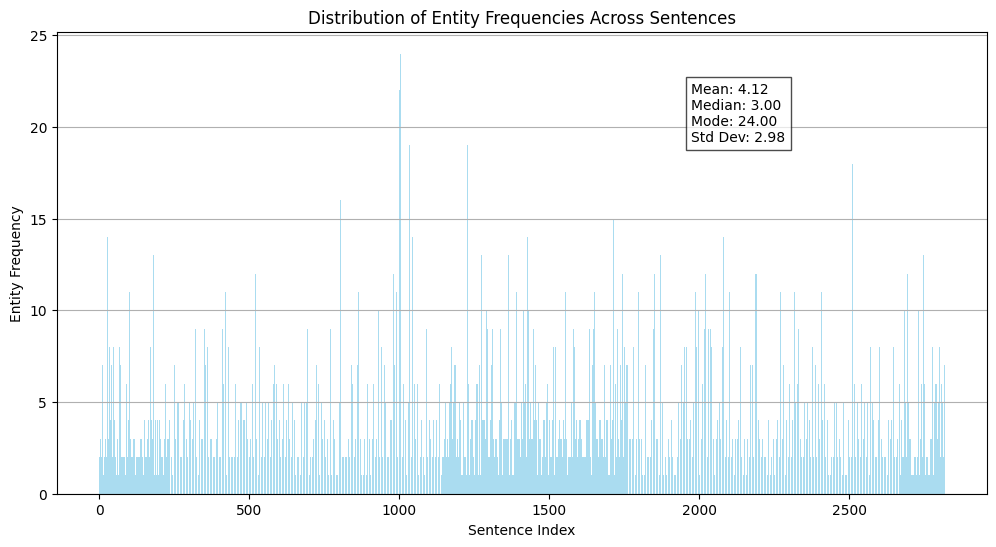

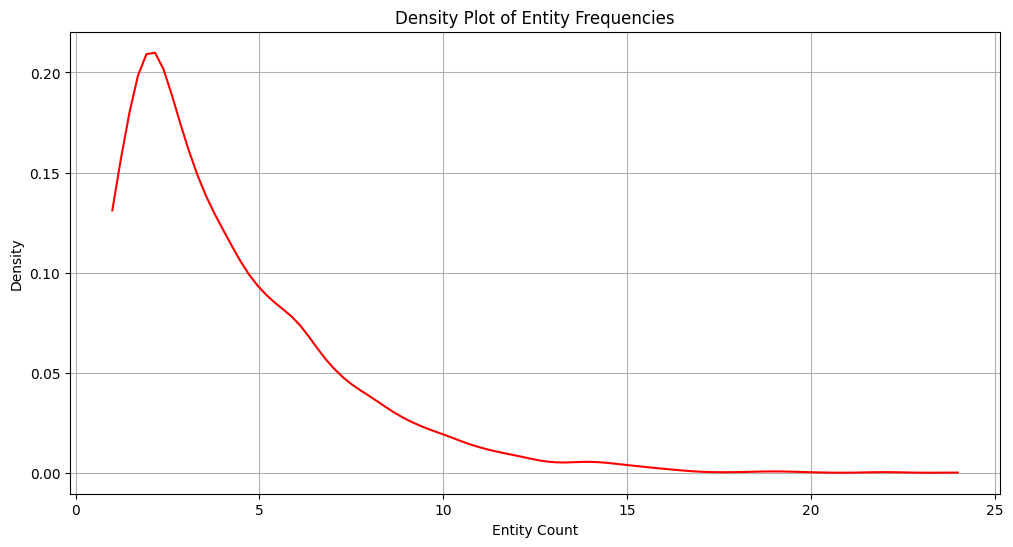

In [3]:
def plot_entity_dist(entity_counts: List[int]):
    """
    Function to plot an entity distribution of the predicted outputs. 
    This function is used after the `entity_count()` for visual reference.

    Argument(s): 
        entity_counts (List[int]): List of counts of entities in each sentence.
    
    Return(s): 
        None
    """

    sentence_indices = list(range(len(entity_counts)))

    # Calculate basic statistics
    mean = np.mean(entity_counts)
    median = np.median(entity_counts)
    mode = max(entity_counts, key=lambda value: int(value))# Safely extract mode
    std_dev = np.std(entity_counts)

    # Plotting the bar chart for entity counts
    plt.figure(figsize=(12, 6))
    plt.bar(sentence_indices, entity_counts, color='skyblue', alpha=0.7, label="Entity Count")
    
    # Adding labels and title
    plt.xlabel('Sentence Index')
    plt.ylabel('Entity Frequency')
    plt.title('Distribution of Entity Frequencies Across Sentences')

    # Adding a grid for better visualization
    plt.grid(axis='y')

    # Add statistics on the plot
    stats_text = (f"Mean: {mean:.2f}\n"
                  f"Median: {median:.2f}\n"
                  f"Mode: {mode:.2f}\n"
                  f"Std Dev: {std_dev:.2f}")
    
    # Add the statistics box on the plot
    plt.text(len(entity_counts) * 0.7, max(entity_counts) * 0.8, stats_text, 
             bbox=dict(facecolor='white', alpha=0.7))

    # Optional: Add a density plot for visualizing the distribution curve
    plt.figure(figsize=(12, 6))
    density = stats.gaussian_kde(entity_counts)
    x_vals = np.linspace(min(entity_counts), max(entity_counts), 100)
    plt.plot(x_vals, density(x_vals), color='red', label='Density Curve')
    
    # Add axis labels and grid
    plt.xlabel('Entity Count')
    plt.ylabel('Density')
    plt.title('Density Plot of Entity Frequencies')
    plt.grid()

    # Show both plots
    plt.show()
entity_counts = label_count(examples)
plot_entity_dist(entity_counts=entity_counts)